In [1]:
import sys
sys.path.append('..')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from sklearn.cluster import KMeans

from myutils.stats import corrcoef, acfunc

from src.pca import IPCA
from src.rzd import PlacePriceModel

plt.style.use('seaborn-whitegrid')

In [3]:
data = pd.read_csv('../data/data.csv', parse_dates=['date'], encoding='utf-8')

weekdays = data[['weekday', 'day_name']].drop_duplicates().sort_values(by='weekday')\
    .set_index('weekday')['day_name'].to_dict()

data.head(2)

,date,days,places,price,num,class,train,weekday,day_name,places_frac
0,2021-04-03,1,62.0,3275.0,001А,Купе,001А-Купе,5,Saturday,0.442857
1,2021-04-04,1,33.0,3913.0,001А,Купе,001А-Купе,6,Sunday,0.235714


In [4]:
trains = sorted(data['train'].unique().tolist())
len(trains)

112

## Модель

$$
\begin{cases}
    n(t, \tau) = \mu(\tau) + a(t) V(\tau) + \delta(t, \tau) \\
    C(t, \tau) = b_0 + b_1 n(t, \tau) + \varepsilon(t, \tau)
\end{cases}
$$

Значения метрик (доля объяснённой дисперсии для PCA и коэф-т детерминации для лин. регрессии) по разным поездам.

In [5]:
maxdays = 30

In [6]:
models = {}
metrics = []

for train in trains:
    train_data = data[(data['train'] == train) & (data['days'] <= maxdays)]

    places = train_data.pivot(index='date', columns='days', values='places_frac')
    prices = train_data.pivot(index='date', columns='days', values='price')
    
    model = PlacePriceModel()
    
    try:
        model.fit(places, prices)
        models[train] = model
        
        train_num, train_class = train.split('-')
        metrics.append((train_num, train_class, model.explained_variance, model.r2))
        
    except Exception as e:
        print(train, e)
    
metrics = pd.DataFrame(metrics, columns=['num', 'class', 'explained', 'r2'])

metrics.head()

,num,class,explained,r2
0,001А,Купе,0.852198,0.079679
1,002А,Купе,0.782705,0.064700
2,005А,СВ,0.868498,0.105069
3,006А,СВ,0.870277,0.065979
4,701Н,СВ,0.609730,0.805482


In [7]:
def truncate_values(df: pd.DataFrame, th: float, fill_value: float = np.nan) -> pd.DataFrame:
    df = df.copy()
    df.values[np.abs(df.values) < th] = fill_value
    
    return df

In [8]:
fig, axes = plt.subplots(ncols=4)
fig.set_size_inches(15, 10)
fig.subplots_adjust(wspace=0.7)
ax1, ax2, ax3, ax4 = axes.flatten()

explained = metrics.pivot(index='num', columns='class', values='explained')
r2 = metrics.pivot(index='num', columns='class', values='r2')

sns.heatmap(explained, ax=ax1, cbar_kws={'aspect': 50, 'pad': 0.2})
ax1.set_title('PCA explained var.')

explained = truncate_values(explained, th=0.85)

sns.heatmap(explained, ax=ax2, cbar_kws={'aspect': 50, 'pad': 0.2})
ax2.set_title('(truncated at 0.85)')

sns.heatmap(r2, ax=ax3, cmap='viridis', cbar_kws={'aspect': 50, 'pad': 0.2})
ax3.set_title('regression r2')

r2 = truncate_values(r2, th=0.5)

sns.heatmap(r2, ax=ax4, cmap='viridis', cbar_kws={'aspect': 50, 'pad': 0.2})
ax4.set_title('(truncated at 0.5)')

plt.savefig('../data/figures/model_metrics.pdf', transparent=True, bbox_inches='tight')
plt.close()

In [9]:
metrics.loc[metrics['explained'] <= 0.65, ['num', 'class']]

,num,class
4,701Н,СВ
6,702Н,СВ
29,752А,B2
48,757А,B1
50,757А,C1


### Визуализация парной регрессии по поездам

In [10]:
a = {}
mean = {}
v = {}

for train, model in models.items():
    if model.explained_variance >= 0.85:
        a[train] = model.a
        mean[train] = model.mean
        v[train] = model.v

a = pd.DataFrame(a)
v = pd.DataFrame(v).T
mean = pd.DataFrame(mean).T

a.reset_index().to_csv('../data/principal_components.csv', index=False)

### $a(t)$

In [11]:
ncols = 6
nrows = a.shape[1] // ncols + (a.shape[1] % ncols > 0)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(4 * ncols, 3 * nrows)
fig.subplots_adjust(wspace=0.3, hspace=0.75)
axes = axes.flatten()

for train, ax in zip(a.columns, axes):
    a[train].plot(ax=ax, c='C2', lw=1, marker='.', markersize=2)
    
    ax.set_title(train)
    ax.set_xlabel(None)

for i in range(a.shape[1], len(axes)):
    axes[i].axis('off')
    
plt.savefig('../data/figures/pcs.pdf', transparent=True, bbox_inches='tight')
plt.close()

In [12]:
ncols = 6
nrows = a.shape[1] // ncols + (a.shape[1] % ncols > 0)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(4 * ncols, 3 * nrows)
fig.subplots_adjust(wspace=0.3, hspace=0.5)
axes = axes.flatten()

for train, ax in zip(a.columns, axes):
    s = a[train].copy()
    s = s.dropna()
    
    acf = acfunc(s, method='spearman', maxlag=21)
    
    ax.plot(acf, lw=1)
    ax.fill_between(acf.index, acf.values, alpha=0.2)
    
    vmax = acf.abs().max() * 1.1
    ax.set_ylim(-vmax, vmax)
    
    ax.axhline(c='k', lw=0.5, ls='dashed', zorder=1)
    ax.set_title(train)

for i in range(a.shape[1], len(axes)):
    axes[i].axis('off')
    
plt.savefig('../data/figures/pcs_acf.pdf', transparent=True, bbox_inches='tight')
plt.close()

## Кластеризация по $\mu(\tau)$

Text(0.5, 0, 'days until departure')

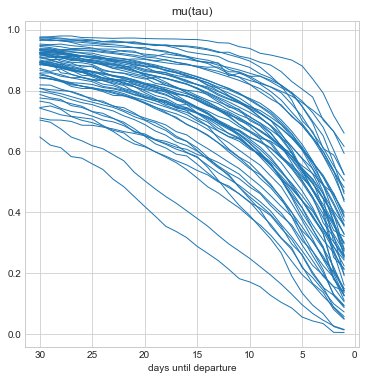

In [13]:
plt.figure(figsize=(6, 6))

for _, row in mean.iterrows():
    plt.plot(row, c='C0', lw=1)
    
plt.gca().invert_xaxis()

plt.title('mu(tau)')
plt.xlabel('days until departure')

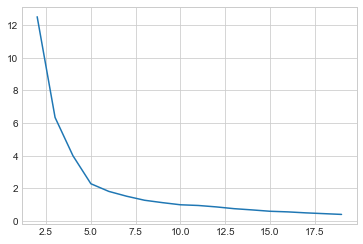

In [14]:
inertia = pd.Series({k: KMeans(k).fit(mean.values).inertia_ for k in range(2, 20)})
inertia.plot();

Векторы $\mu(\tau)$ по разным кластерам.

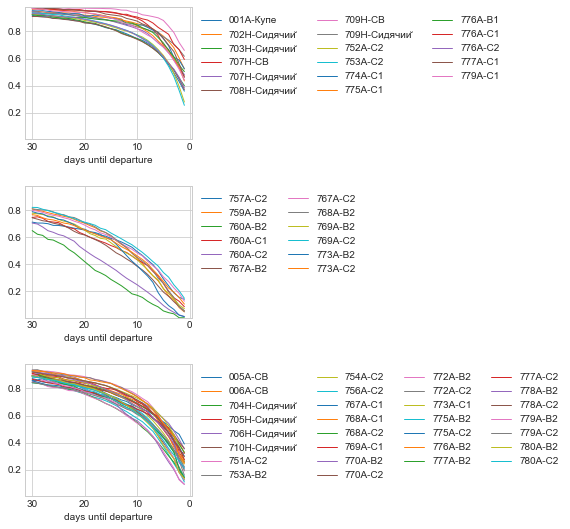

In [15]:
k = 3
kmeans = KMeans(n_clusters=k).fit(mean.values)
mu_clusters = kmeans.predict(mean.values)

ncols = 1
nrows = k

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)
fig.subplots_adjust(hspace=0.35)
axes = axes.flatten()

mu_min = mean.min().min()
mu_max = mean.max().max()

for cluster, ax in zip(np.unique(mu_clusters), axes):
    mean_i = mean.loc[mu_clusters == cluster]
    
    mean_i.T.plot(ax=ax, lw=1)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=mean_i.shape[0] // 8 + 1)
    ax.set_xlabel('days until departure')
    ax.set_ylim(mu_min, mu_max)
    
    ax.invert_xaxis()

plt.savefig('../data/figures/mean_vector_clusters.pdf', transparent=True, bbox_inches='tight')
# plt.close()

## Кластеризация по $V(\tau)$

Text(0.5, 0, 'days until departure')

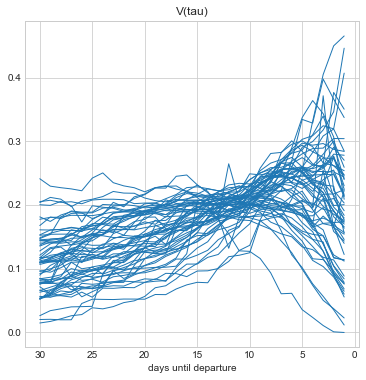

In [16]:
plt.figure(figsize=(6, 6))

for _, row in v.iterrows():
    plt.plot(row, c='C0', lw=1)
    
plt.gca().invert_xaxis()

plt.title('V(tau)')
plt.xlabel('days until departure')

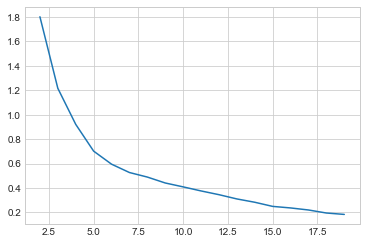

In [17]:
inertia = pd.Series({k: KMeans(k).fit(v.values).inertia_ for k in range(2, 20)})
inertia.plot();

Векторы $V(\tau)$ по разным кластерам.

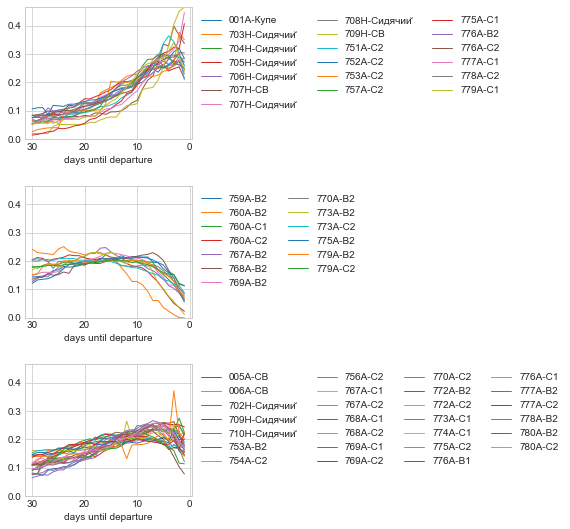

In [21]:
k = 3
kmeans = KMeans(n_clusters=k).fit(v.values)
eig_clusters = kmeans.predict(v.values)

ncols = 1
nrows = k

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)
fig.subplots_adjust(hspace=0.35)
axes = axes.flatten()

vmin = v.min().min()
vmax = v.max().max()

for cluster, ax in zip(np.unique(eig_clusters), axes):
    vi = v.loc[eig_clusters == cluster]
    
    vi.T.plot(ax=ax, lw=1)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=vi.shape[0] // 8 + 1)
    ax.set_xlabel('days until departure')
    ax.set_ylim(vmin, vmax)
    
    ax.invert_xaxis()

for i in range(k, len(axes)):
    axes[i].axis('off')
    
plt.savefig('../data/figures/eigenvector_clusters.pdf', transparent=True, bbox_inches='tight')
# plt.close()

### Би-кластеризация

In [22]:
biclusters = np.array(list(map(lambda x, y: f'{x}-{y}', mu_clusters, eig_clusters)))

biclusters

array(['0-0', '2-2', '2-2', '0-2', '0-0', '2-0', '2-0', '2-0', '0-0',
       '0-0', '0-0', '0-0', '0-2', '2-2', '2-0', '0-0', '2-2', '0-0',
       '2-2', '2-2', '1-0', '1-1', '1-1', '1-1', '1-1', '1-1', '2-2',
       '1-2', '1-1', '2-2', '2-2', '1-1', '2-2', '1-2', '2-1', '2-2',
       '2-2', '2-2', '1-1', '2-2', '1-1', '0-2', '2-1', '0-0', '2-2',
       '0-2', '2-0', '0-2', '0-0', '2-2', '0-0', '2-2', '2-2', '2-0',
       '2-1', '0-0', '2-1', '2-2', '2-2'], dtype='<U3')

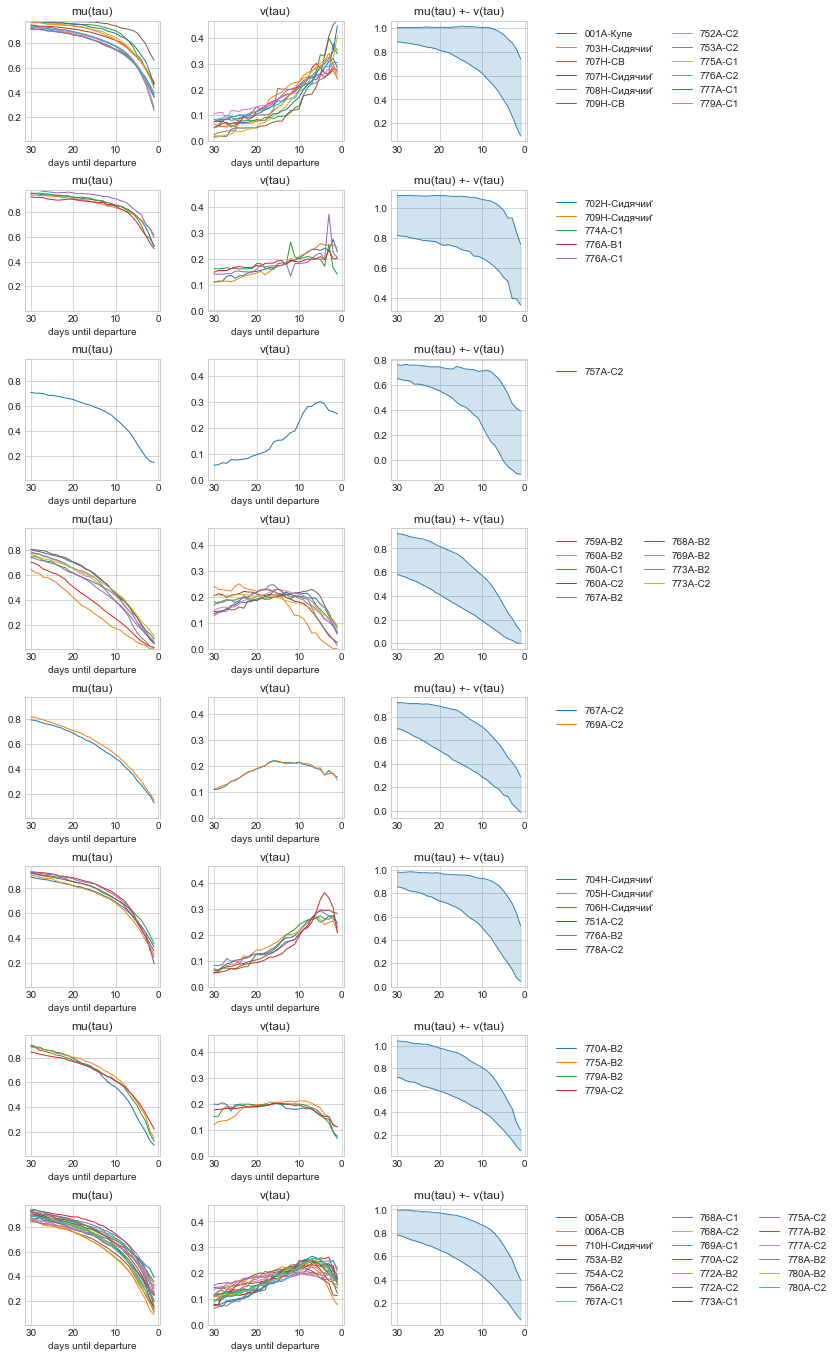

In [23]:
ncols = 3
nrows = np.unique(biclusters).size

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)
fig.subplots_adjust(hspace=0.4, wspace=0.35)

for cluster, (ax1, ax2, ax3) in zip(np.unique(biclusters), axes):
    mean_i = mean.loc[biclusters == cluster]
    
    mean_i.T.plot(ax=ax1, lw=1, legend=False)
    ax1.set_title('mu(tau)')
    ax1.set_xlabel('days until departure')
    ax1.set_ylim(mu_min, mu_max)
    
    ax1.invert_xaxis()
    
    vi = v.loc[biclusters == cluster]
    
    vi.T.plot(ax=ax2, lw=1)
    ax2.legend(loc='upper left', bbox_to_anchor=(2.5, 1), ncol=vi.shape[0] // 8 + 1)
    ax2.set_title('v(tau)')
    ax2.set_xlabel('days until departure')
    ax2.set_ylim(vmin, vmax)
    
    ax2.invert_xaxis()
    
    mean_i = mean_i.mean(axis=0)
    vi = vi.mean(axis=0)
    
    lower = mean_i - vi
    upper = mean_i + vi
    
    ax3.plot(lower, c='C0', lw=0.8)
    ax3.plot(upper, c='C0', lw=0.8)
    ax3.fill_between(mean_i.index, lower, upper, color='C0', alpha=0.2)
    ax3.set_title('mu(tau) +- v(tau)')
    ax2.set_xlabel('days until departure')
    
    ax3.invert_xaxis()

plt.savefig('../data/figures/biclusters.pdf', transparent=True, bbox_inches='tight')
# plt.close()

Расшифровка моделей для каждого кластера.